[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1xiqm3r-5IbbGHTLH7uh6ygUqtAKbYFAm?usp=sharing)

<h1 align="center">
  <a href="https://portkey.ai">
    <img width="300" src="https://analyticsindiamag.com/wp-content/uploads/2023/08/Logo-on-white-background.png" alt="portkey">
  </a>
</h1>

# Video Processing with GPT-4o

[Portkey](https://app.portkey.ai/) is the Control Panel for AI apps. With it's popular AI Gateway and Observability Suite, hundreds of teams ship reliable, cost-efficient, and fast apps.

With Portkey, you can

 - Connect to 150+ models through a unified API,
 - View 40+ metrics & logs for all requests,
 - Enable semantic cache to reduce latency & costs,
 - Implement automatic retries & fallbacks for failed requests,



You will need Portkey and OpenAIAI API keys to run this notebook.

- Sign up for Portkey and generate your API key [here](https://app.portkey.ai/).
- Get your OpenAI API key [here](https://console.OpenAI.com/keys)

# Dependencies

In [ ]:
!pip install -qU portkey-ai openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders
from google.colab import userdata

### Using Portkey with OpenAI Client

In [ ]:
portkey = OpenAI(
    api_key= userdata.get('OPENAI_API_KEY'), ## replace it your OpenAI API key
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="openai",
        api_key= userdata.get('PORTKEY_API_KEY'), ## replace it your Portkey API key
    )
)

Setup for Video Processing
We'll use two python packages for video processing - ```opencv-python``` and ```moviepy```.

These require ```ffmpeg```

In [ ]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=f1b8e188b7854a5aaed58cdba090f14a7b461d31b6118b0d3471652c49aac9ff
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
%pip install opencv-python --quiet
%pip install moviepy --quiet

## Process the video into two components:
1.Frames

2.Audio

In [ ]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64
import os
from IPython.display import display, Image , Audio
# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "/content/(102) Life Moves Pretty Fast... - YouTube - Google Chrome 2023-07-27 14-31-46.mp4"

Function to process the video

In [ ]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

MoviePy - Writing audio in /content/(102) Life Moves Pretty Fast... - YouTube - Google Chrome 2023-07-27 14-31-46.mp3


MoviePy - Done.
Extracted 25 frames
Extracted audio to /content/(102) Life Moves Pretty Fast... - YouTube - Google Chrome 2023-07-27 14-31-46.mp3


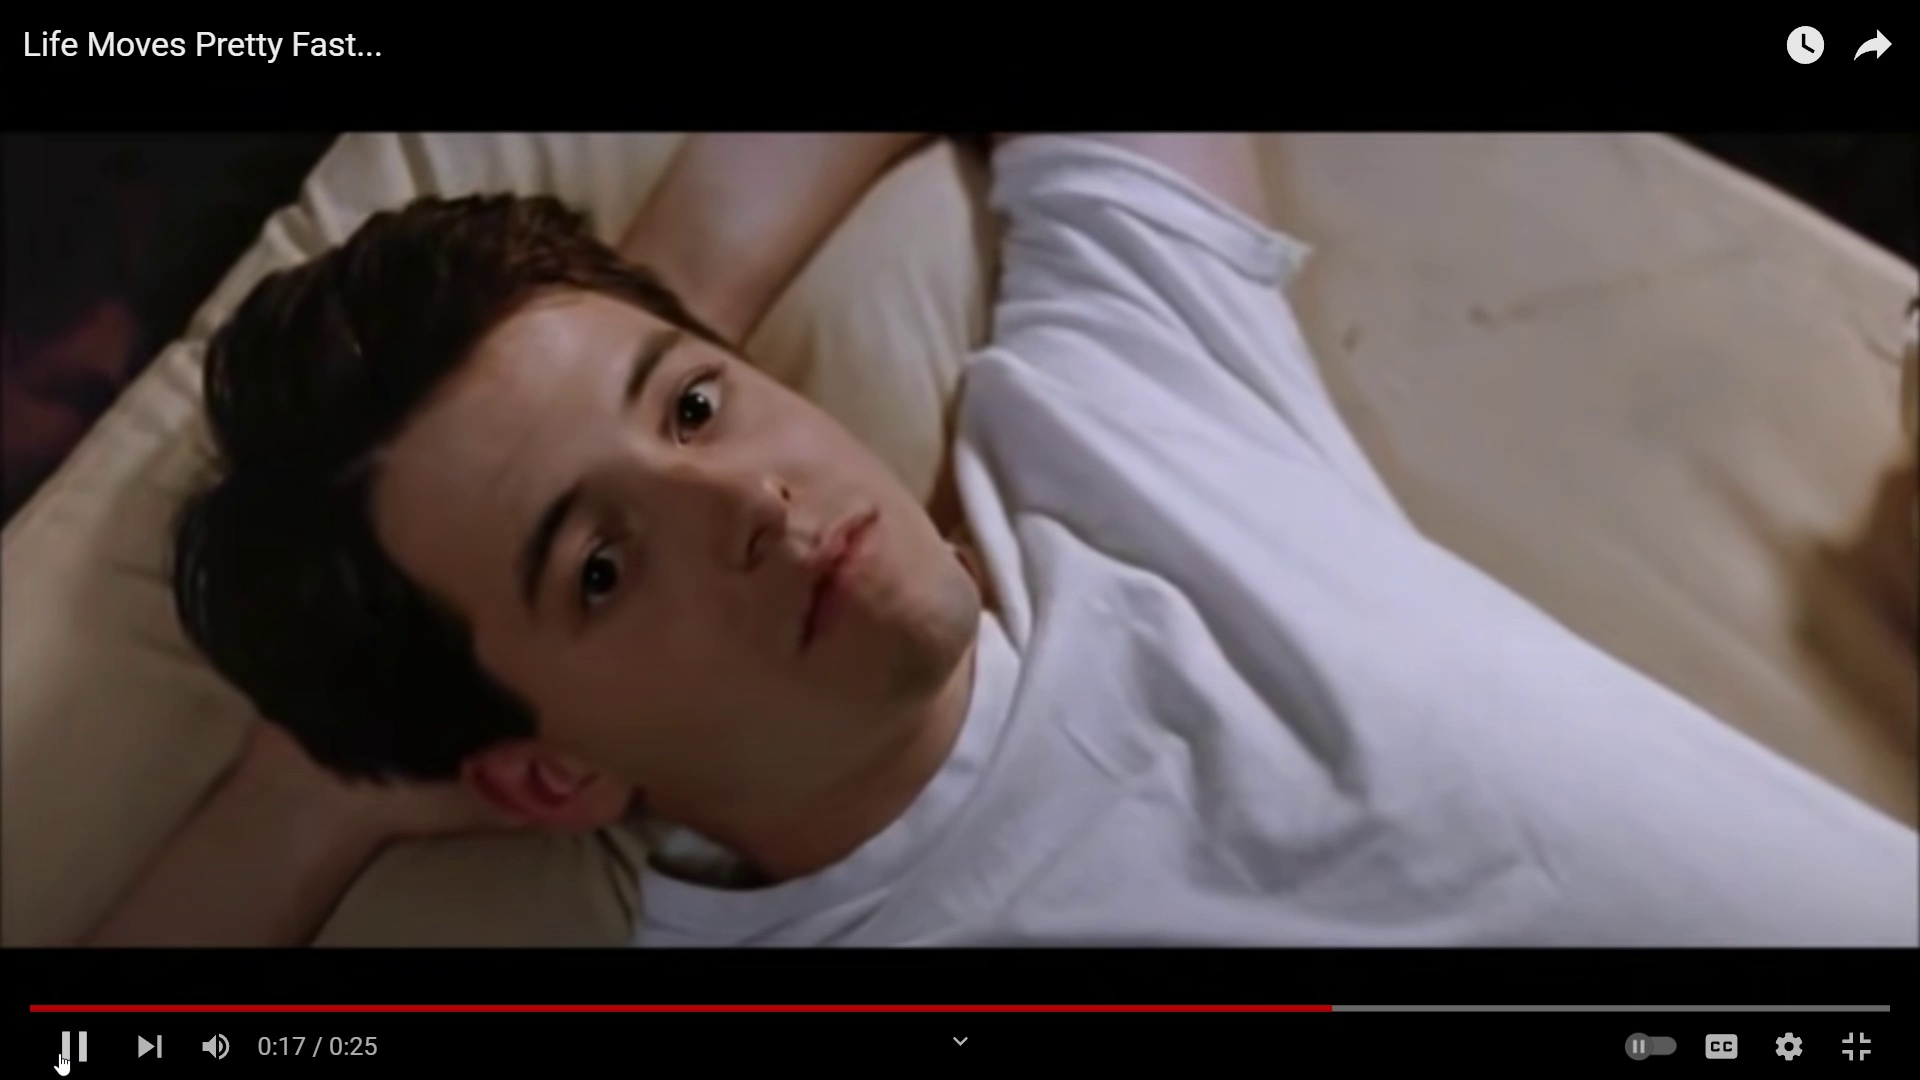

In [ ]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

## Visual Summary
The visual summary is generated by sending the model only the frames from the video. With just the frames, the model is likely to capture the visual aspects, but will miss any details discussed by the speaker.

In [ ]:
response = portkey.chat.completions.create(
    model="gpt-4o",
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

### Video Summary

The video appears to be a scene from a movie. It starts with a view of a room decorated with various posters, including a large Union Jack flag, a "Simple Minds" poster, and a "Garet Claire" poster. The camera then shifts to a young man lying in bed, covered with a blanket. He appears to be waking up and starts talking directly to the camera, breaking the fourth wall. He seems to be sharing some thoughts or advice, as he looks contemplative and serious. The scene ends with him still lying in bed, looking thoughtful. The video's title, "Life Moves Pretty Fast...", suggests that the young man might be reflecting on the pace of life.


##Audio Summary
The audio summary is generated by sending the model the audio transcript. With just the audio, the model is likely to bias towards the audio content, and will miss the context provided by the presentations and visuals.

```audio``` input for GPT-4o isn't currently available but will be coming soon! For now, we use our existing ```whisper-1``` model to process the audio

In [ ]:
transcription = portkey.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)
## OPTIONAL: Uncomment the line below to print the transcription
#print("Transcript: ", transcription.text + "\n\n")

response = portkey.chat.completions.create(
    model="gpt-4o",
    messages=[
    {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
    {"role": "user", "content": [
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

In the transcription, the speaker emphasizes the rapid pace of life, suggesting that if one doesn't take the time to pause and observe their surroundings occasionally, they might miss important moments.


## Audio + Visual Summary
The Audio + Visual summary is generated by sending the model both the visual and the audio from the video at once. When sending both of these, the model is expected to better summarize since it can perceive the entire video at once.

In [ ]:
# Generate a summary with visual and audio
response = portkey.chat.completions.create(
    model="gpt-4o",
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

**Video Summary:**

The video opens with a shot of a room decorated with various posters, including a large Union Jack flag, a "Simple Minds" poster, and a "Garet Claire" poster. The scene then transitions to a young man lying in bed, covered with a blanket. He appears to be waking up and begins speaking directly to the camera. He says, "Yep, I said it before and I'll say it again. Life moves pretty fast. You don't stop and look around once in a while. You could miss it." The video ends with him lying back on his pillow, emphasizing the importance of taking time to appreciate life.
